In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import chain
from rolling_window import rolling_window
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing

### Problem 1

$$c_{1} = f(x_{1})$$
$$c_{2} = \frac{f(x_{2})-f(x_{1})}{x_{2}-x_{1}}$$
$$c_{3} = \frac{\frac{f(x_{3})-f(x_{1})}{x_{3}-x_{1}} - \frac{f(x_{2})-f(x_{1})}{x_{2}-x_{1}}}{x_{3} - x_{2}}$$

Each divided difference represents a secant slope for a derivative of $f$ between a pair of adjacent points: $c_{2}$ is the slope between points $x_{2}$ and $x_{1}$ in the first derivative, $c_{2}$ is the slope between points $x_{3}$ and $x_{2}$ in the second derivative, etc...

### Problem 2

In [3]:
def coef(x, y):
    x.astype(float)
    y.astype(float)
    n = len(x)
    a = []
    for i in range(n):
        a.append(y[i])

    for j in range(1, n):
        for i in range(n-1, j-1, -1):
            a[i] = float(a[i]-a[i-1])/float(x[i]-x[i-j])
    return np.array(a)

def eval(r, coeff, x):
    x.astype(float)
    n = len( coeff ) - 1
    temp = coeff[n]
    for i in range( n - 1, -1, -1 ):
        temp = temp * ( r - x[i] ) + coeff[i]
    return temp

In [4]:
def apply_function(x):
    return np.reciprocal(np.power(x,2)+1)

x_arrs = [np.linspace(-5, 5, n) for n in [np.power(2, p) for p in range(1, 10)]]
y_for_x_arrs = [np.apply_along_axis(apply_function, 0, arr) for arr in x_arrs]
coefficients = [(coef(x, y), x) for x, y in zip(x_arrs, y_for_x_arrs)]

In [5]:
x = np.linspace(-5, 5, np.power(2, 10))
y_interp = [np.apply_along_axis(eval, 0, x, _coeff, _x) for _coeff, _x in coefficients]
y_func = np.apply_along_axis(apply_function, 0, x)

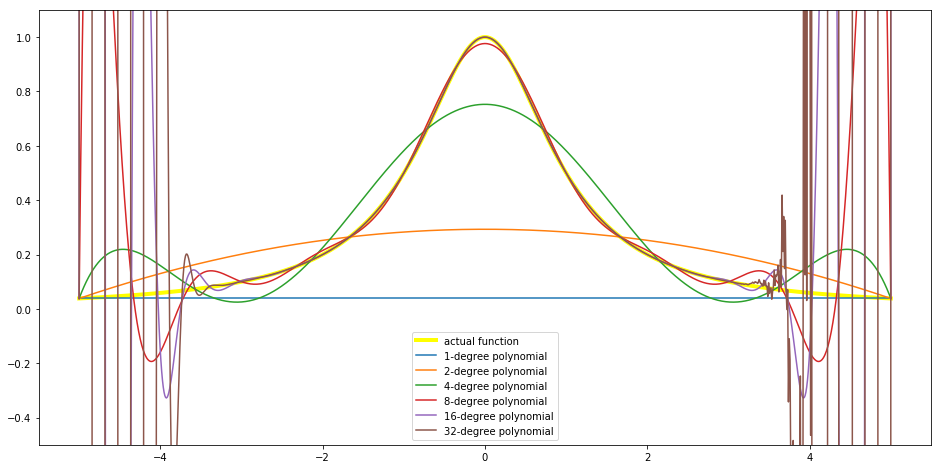

In [6]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
ax.plot(x, y_func, label="actual function", linewidth=4, color="yellow")
ax.set_ylim(-0.5,1.1)
for n, y in zip(range(0,6), y_interp[0:6]):
    ax.plot(x, y, label=f"{np.power(2, n)}-degree polynomial")
ax.legend(loc="best")
fig

This behavior is called Runge's phenomenon and is caused by rapidly changing higher order derivatives of the estimated function.

### Problem 3

We are looking for an $h = \frac{\beta - \alpha}{n - 1}$, where $\beta$ and $\alpha$ are the upper and lower limits of the value range, and n is the number of tabulated values, such that $h \leq \delta$, where $\delta$ is the desired degree of accuracy. For a first degree polynomial, $h \leq \sqrt{\frac{8\delta}{M_2}}$, where $M_2$ is the upper bound of $f^{(2)}$ in $\left[\alpha,\beta\right]$. For a second degree polynomial, $h \leq \sqrt[3]{\frac{12\delta}{M_3}}$, where $M_3$ is the upper bound of $f^{(3)}$ in $\left[\alpha,\beta\right]$. $M_2 = \frac{1}{2}$ and $M_3 = \frac{1}{4}$ for all $x \in \left[1,1000\right]$.

In [7]:
error_bounds = [1/(np.power(10,i)) for i in range(1, 16)]
min_spacings = [(np.sqrt(8*bound/.5), np.cbrt(12*bound/.25)) for bound in error_bounds]

In [8]:
min_spacings_df = pd.DataFrame(data=min_spacings, columns=["1st degree", "2nd degree"], index=pd.Index(data=error_bounds, name="Error bound"))
min_spacings_df

,1st degree,2nd degree
Error bound,,
1.000000e-01,1.264911e+00,1.686865
1.000000e-02,4.000000e-01,0.782974
1.000000e-03,1.264911e-01,0.363424
1.000000e-04,4.000000e-02,0.168687
1.000000e-05,1.264911e-02,0.078297
1.000000e-06,4.000000e-03,0.036342
1.000000e-07,1.264911e-03,0.016869
1.000000e-08,4.000000e-04,0.007830
1.000000e-09,1.264911e-04,0.003634


### Problem 4

In [9]:
image = Image.open("bird.jpg", "r")

In [10]:
imgarr = np.array(image)
imgarr.shape

(360, 640)

In [11]:
#works for grayscale images
def interpolate(unit):
    unit = np.array(unit, copy=False)
    height, width = unit.shape
    def _interpolate(row, col): 
        if unit[row, col] == 0:
            unit[row, col] = (1-(row/(height-1)))*((1-(col/(width-1)))*unit[width-1,0] + (col/(width-1))*unit[width-1,height-1]) + \
                (row/(height-1))*((1 - col/(width-1))*unit[0,0] + (col/(width-1))*unit[0,width-1])   
    for row in range(1, height-1):
        for col in range(0, height):
            _interpolate(row, col)
    for col in range(1, width-1):
        _interpolate(0, col)
        _interpolate(height-1, col)
    return unit

def upscale(img, factor):
    try:
        arr = np.array(img, copy=False)
    except:
        raise Exception("arr is not an array")
    height, width = arr.shape
    new_height, new_width = height*factor - factor + 1, width*factor - factor + 1
    if (new_width > width and new_height > height) is False:
        return img
    new_img = np.zeros([new_height, new_width], dtype=np.uint8)
    new_img[::factor,::factor] = img
    interpolation_units = rolling_window(new_img, (factor+1, factor+1), asteps=(factor,factor))
    #Parallel(n_jobs=multiprocessing.cpu_count())(delayed(interpolate)(unit) for unit in chain.from_iterable([row for row in interpolation_units]))
    for unit in chain.from_iterable([row for row in interpolation_units]):
        interpolate(unit)
    return new_img

In [12]:
new_image_arr = upscale(image, 8)
new_image2_arr = image
for i in range(0, 2):
    new_image2_arr = upscale(new_image2_arr, 3)

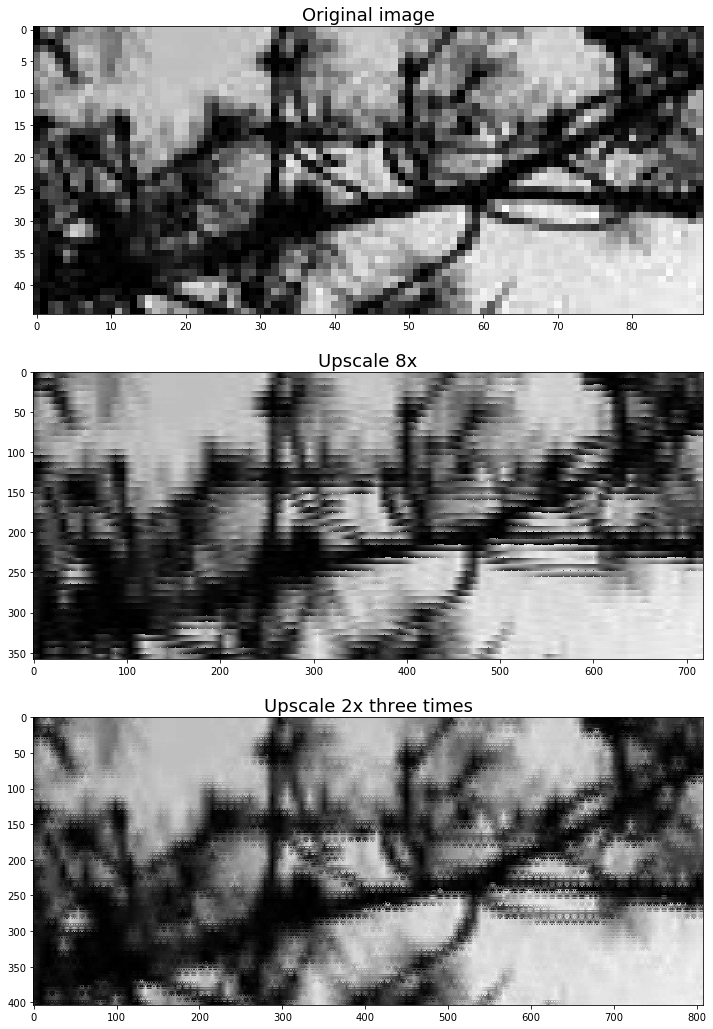

In [14]:
fig_width, fig_height = (12, 18)
fig = plt.figure(figsize=(fig_width, fig_height))
for i, title, img in zip(range(1, 4), ["Original image", "Upscale 8x", "Upscale 2x three times"], [imgarr, new_image_arr, new_image2_arr]):
    ax = fig.add_subplot(3, 1, i)
    height, width = int((img.shape[0]/4) * (fig_height / fig_width) / 3), int(img.shape[0]/4)
    ax.imshow(img[:height,:width], cmap="gray", aspect="auto")
    ax.set_title(title, {"fontsize": 18})
fig

Repeated interpolation appears to produce superior results due to decreased interpolation error.